# Subtype and Stage Inference (SuStaIn)

In [34]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

import pySuStaIn as ps
from jmspack.utils import apply_scaling

In [135]:
from sklearn.model_selection import StratifiedKFold

In [24]:
from SuStaIn_extras.simfuncs import generate_random_Zscore_sustain_model, generate_data_Zscore_sustain

In [25]:
if "jms_style_sheet" in plt.style.available:
    plt.style.use("jms_style_sheet")

### Look at what the data looks like

In [35]:
data = pd.read_csv("https://raw.githubusercontent.com/ucl-pond/pySuStaIn/master/notebooks/SimulatedData.csv")
data.head()

,RID,Diagnosis,Age,Headsize,Biomarker1,Biomarker2,Biomarker3,Biomarker4,Biomarker5
0,1,1,63.501953,0.920706,132.511729,180.698267,120.119201,159.200991,190.197486
1,2,1,61.240101,0.952784,154.500427,194.299318,179.148420,173.515194,237.807726
2,3,1,52.108876,1.061493,140.878957,170.449488,160.945261,163.988839,207.271331
3,4,1,65.989165,0.871652,146.361556,175.111234,164.769410,114.437784,184.657121
4,5,1,65.071640,1.147264,167.254806,203.470447,232.783278,212.857075,245.588402


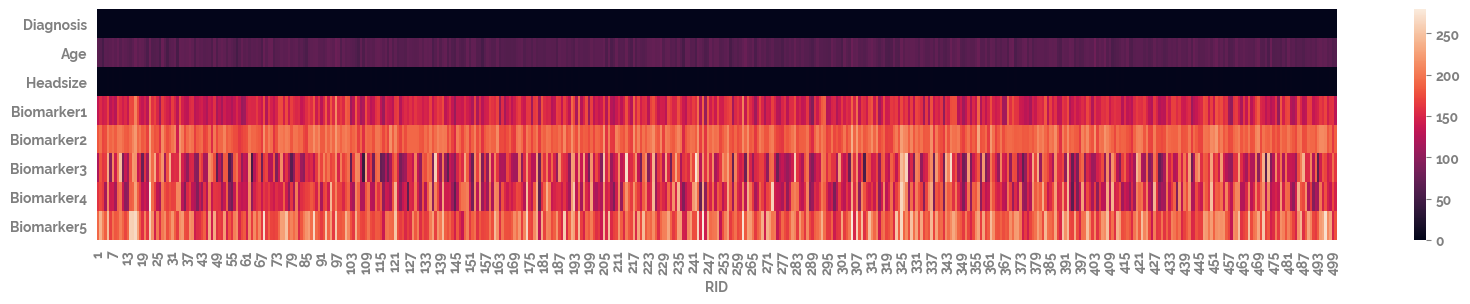

In [36]:
_ = plt.figure(figsize=(20, 3))
_ = sns.heatmap(data=data.set_index("RID").T)

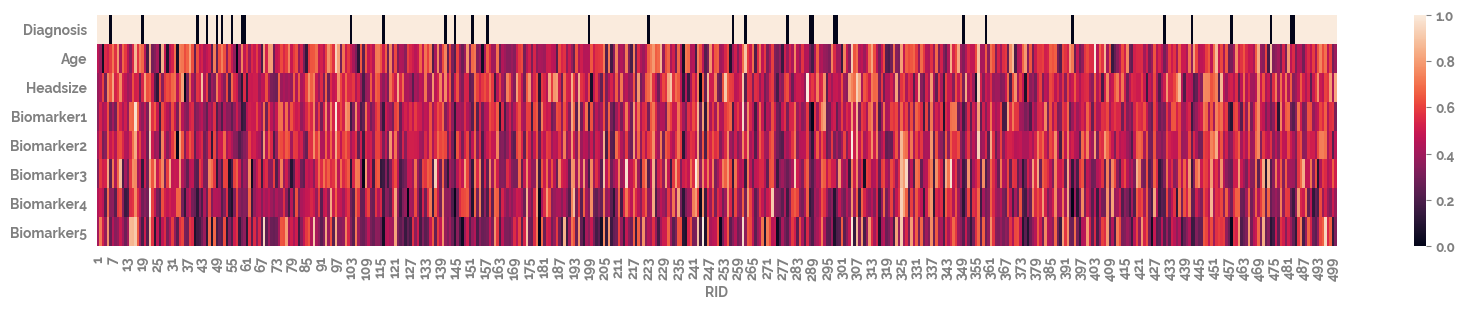

In [37]:
_ = plt.figure(figsize=(20, 3))
_ = sns.heatmap(data=data
                .set_index("RID")
                .pipe(apply_scaling)
                .T)

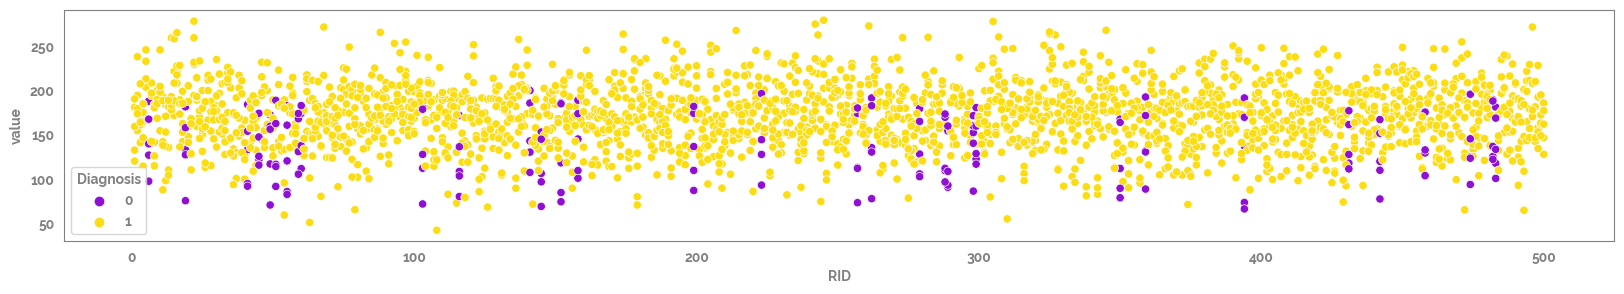

In [44]:
_ = plt.figure(figsize=(20, 3))
_ = sns.scatterplot(data=data
                # .set_index("RID")
                # .pipe(apply_scaling)
                # .reset_index()
                .drop(["Age", "Headsize"], axis=1)
                .melt(id_vars=["RID","Diagnosis"])
                ,
                x="RID",
                y="value",
                hue="Diagnosis")
_ = sns.despine()

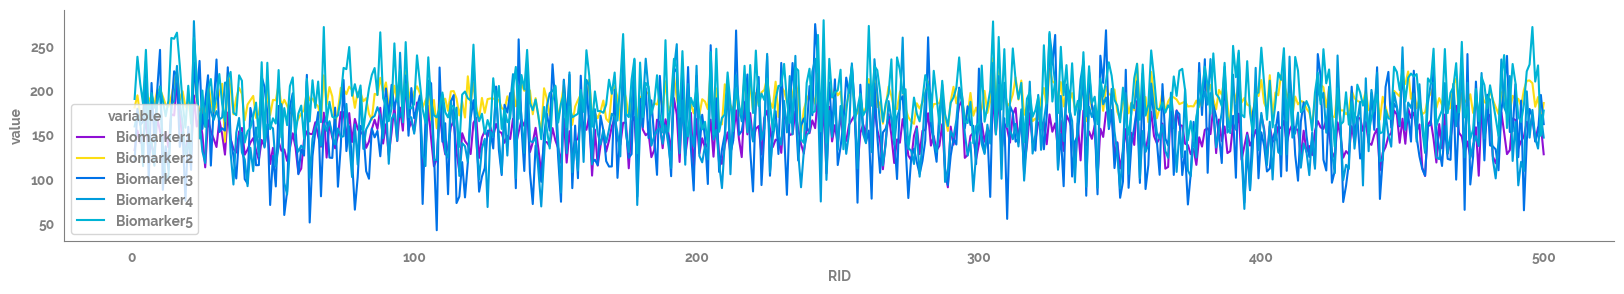

In [46]:
_ = plt.figure(figsize=(20, 3))
_ = sns.lineplot(data=data
                # .set_index("RID")
                # .pipe(apply_scaling)
                # .reset_index()
                .drop(["Age", "Headsize"], axis=1)
                .melt(id_vars=["RID","Diagnosis"])
                ,
                x="RID",
                y="value",
                hue="variable")
_ = sns.despine()

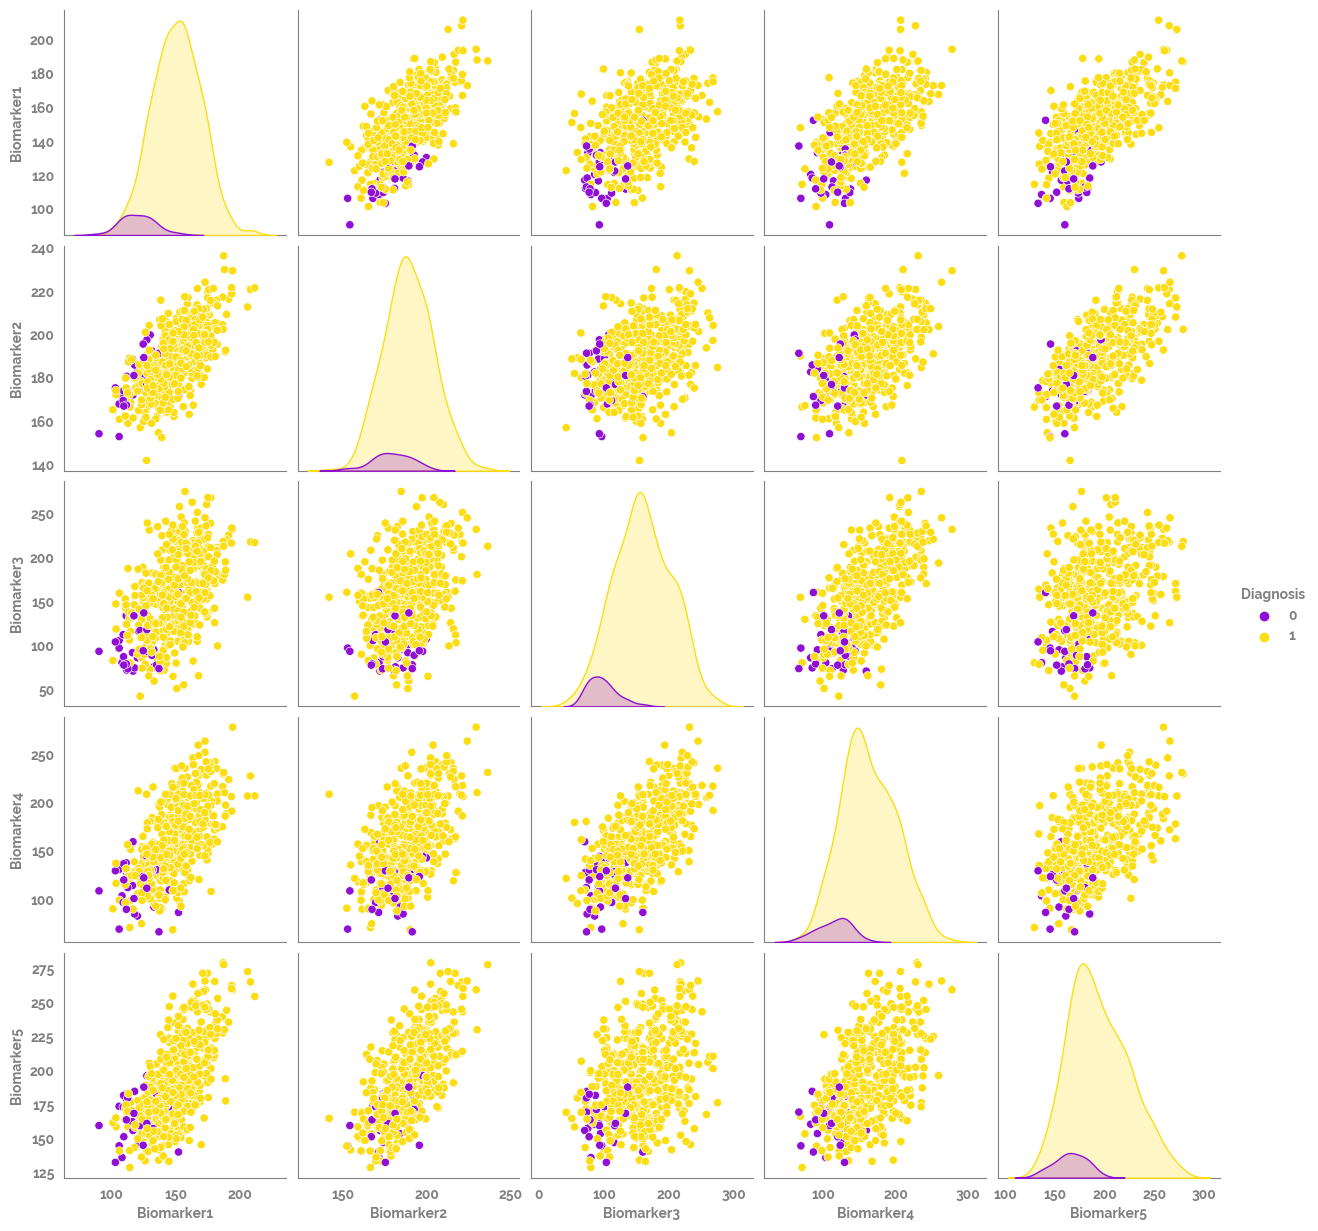

In [144]:
_ = sns.pairplot(data=data.drop(["RID", "Age", "Headsize"], axis=1), hue="Diagnosis")

# Prepare SuStaIn inputs

Now that we've z-scored our data, let's start prepping the many SuStaIn inputs

In [112]:
zdata=(data
       .set_index(["RID", "Diagnosis"])
       .pipe(apply_scaling, method="Standard")
       .reset_index()
       )

In [113]:
Biomarker_list=zdata.filter(regex="Biom").columns.tolist()
N = len(Biomarker_list)         # number of biomarkers

SuStaInLabels = Biomarker_list
Z_vals = np.array([[1,2,3]]*N)     # Z-scores for each biomarker
Z_max  = np.array([5]*N)           # maximum z-score

In [114]:
print(Z_vals)

[[1 2 3]
 [1 2 3]
 [1 2 3]
 [1 2 3]
 [1 2 3]]


In [115]:
# Input the settings for z-score SuStaIn
# To make the tutorial run faster I've set 
# N_startpoints = 10 and N_iterations_MCMC = int(1e4)
# I recommend using N_startpoints = 25 and 
# N_iterations_MCMC = int(1e5) or int(1e6) in general though

N_startpoints = 10
N_S_max = 3
N_iterations_MCMC = int(1e4)
output_folder = os.path.join(os.getcwd(), 'SuStaIn_example_output')
dataset_name = 'SuStaIn_example_output'

# Initiate the SuStaIn object
sustain_input = ps.ZscoreSustain(
                              zdata[Biomarker_list].values,
                              Z_vals,
                              Z_max,
                              SuStaInLabels,
                              N_startpoints,
                              N_S_max, 
                              N_iterations_MCMC, 
                              output_folder, 
                              dataset_name, 
                              False)

# make the output directory if it's not already created
if not os.path.isdir(output_folder):
    os.mkdir(output_folder)

In [116]:
(samples_sequence,
samples_f,
ml_subtype,
prob_ml_subtype,
ml_stage,
prob_ml_stage,
prob_subtype_stage)  = sustain_input.run_sustain_algorithm()

Found pickle file: /Users/jamestwose/Coding/Data-Science/Machine_learning/SuStaIn_example_output/pickle_files/SuStaIn_example_output_subtype0.pickle. Using pickled variables for 0 subtype.
Found pickle file: /Users/jamestwose/Coding/Data-Science/Machine_learning/SuStaIn_example_output/pickle_files/SuStaIn_example_output_subtype1.pickle. Using pickled variables for 1 subtype.
Found pickle file: /Users/jamestwose/Coding/Data-Science/Machine_learning/SuStaIn_example_output/pickle_files/SuStaIn_example_output_subtype2.pickle. Using pickled variables for 2 subtype.


# Evaluate subtypes

Here, we'll plot the log likelihood across MCMC samples, across each subtype. This will give us at least a basic sense of what how many subtypes we should consider looking at

In [117]:
def read_LL_df(file_name, column_name):
    return pd.DataFrame(pd.read_pickle(file_name)[column_name], columns=[column_name])

In [118]:
LL_df = pd.concat([read_LL_df(f"{output_folder}/pickle_files/{dataset_name}_subtype{x}.pickle", 
                      column_name="samples_likelihood") for x in range(N_S_max)], 
          axis=1)

LL_df.columns=[f"Log Likelihood {x}" for x in range(N_S_max)]

LL_df.head()

,Log Likelihood 0,Log Likelihood 1,Log Likelihood 2
0,-3126.082292,-3126.366677,-3128.886094
1,-3126.082292,-3126.366677,-3129.403164
2,-3126.082292,-3126.366677,-3129.431895
3,-3126.082292,-3126.368944,-3129.156358
4,-3126.082292,-3126.494339,-3129.156358


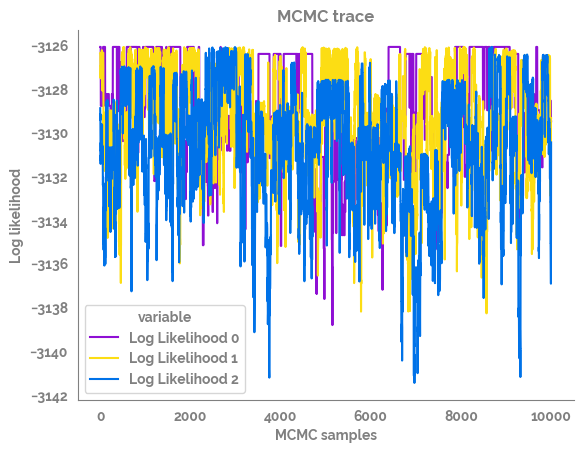

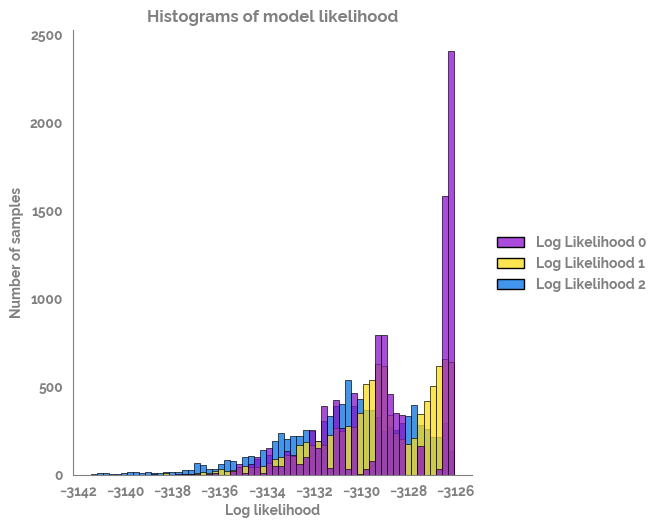

In [119]:
_ = sns.lineplot(data=LL_df.reset_index().melt(id_vars="index"),
                 x="index",
                 y="value",
                 hue="variable")
_ = plt.xlabel('MCMC samples')
_ = plt.ylabel('Log likelihood')
_ = plt.title('MCMC trace')
_ = sns.despine()

_ = sns.displot(data=LL_df)
_ = plt.xlabel('Log likelihood')  
_ = plt.ylabel('Number of samples')  
_ = plt.title('Histograms of model likelihood')

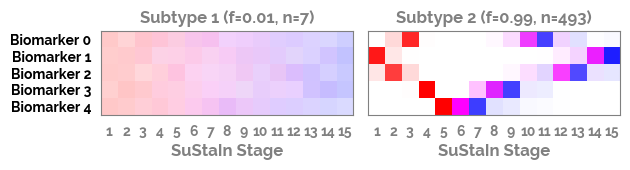

In [120]:
# Let's plot positional variance diagrams to interpret the subtype progressions

s = 1# 1 split = 2 subtypes
M = len(zdata[Biomarker_list].values) 

# get the sample sequences and f
pickle_filename_s = output_folder + '/pickle_files/' + dataset_name + '_subtype' + str(s) + '.pickle'
pk = pd.read_pickle(pickle_filename_s)
samples_sequence = pk["samples_sequence"]
samples_f = pk["samples_f"]

# use this information to plot the positional variance diagrams
tmp=ps.ZscoreSustain._plot_sustain_model(sustain_input,samples_sequence,samples_f,M,subtype_order=(0,1))

# Subtype and stage individuals

In [121]:
# let's take a look at all of the things that exist in SuStaIn's output (pickle) file
pk.keys()

dict_keys(['samples_sequence', 'samples_f', 'samples_likelihood', 'ml_subtype', 'prob_ml_subtype', 'ml_stage', 'prob_ml_stage', 'prob_subtype', 'prob_stage', 'prob_subtype_stage', 'ml_sequence_EM', 'ml_sequence_prev_EM', 'ml_f_EM', 'ml_f_prev_EM'])

In [122]:
# The SuStaIn output has everything we need. We'll use it to populate our dataframe.

s = 1
pickle_filename_s = output_folder + '/pickle_files/' + dataset_name + '_subtype' + str(s) + '.pickle'
pk = pd.read_pickle(pickle_filename_s)

for variable in ['ml_subtype', # the assigned subtype
                 'prob_ml_subtype', # the probability of the assigned subtype
                 'ml_stage', # the assigned stage 
                 'prob_ml_stage',]: # the probability of the assigned stage
    
    # add SuStaIn output to dataframe
    zdata.loc[:,variable] = pk[variable] 

# let's also add the probability for each subject of being each subtype
for i in range(s):
    zdata.loc[:,'prob_S%s'%i] = pk['prob_subtype'][:,i]
zdata.head()

,RID,Diagnosis,Age,Headsize,Biomarker1,Biomarker2,Biomarker3,Biomarker4,Biomarker5,ml_subtype,prob_ml_subtype,ml_stage,prob_ml_stage,prob_S0
0,1,1,-0.276180,-0.787699,-0.830888,-0.535437,-0.780946,-0.007298,-0.066520,0.0,0.988207,0.0,0.172095,0.988207
1,2,1,-0.740595,-0.476933,0.283935,0.399624,0.519579,0.360694,1.500778,0.0,0.988605,1.0,0.131844,0.988605
2,3,1,-2.615462,0.576247,-0.406671,-1.240033,0.118529,0.115789,0.495540,0.0,0.988028,0.0,0.151258,0.988028
3,4,1,0.234506,-1.262940,-0.128704,-0.919541,0.202783,-1.158080,-0.248905,0.0,0.988692,0.0,0.170236,0.988692
4,5,1,0.046116,1.407189,0.930579,1.030132,1.701257,1.372103,1.756912,0.0,0.989070,2.0,0.123890,0.989070


In [123]:
# IMPORTANT!!! The last thing we need to do is to set all "Stage 0" subtypes to their own subtype
# We'll set current subtype (0 and 1) to 1 and 0, and we'll call "Stage 0" individuals subtype 0.

# make current subtypes (0 and 1) 1 and 2 instead
zdata.loc[:,'ml_subtype'] = zdata.ml_subtype.values + 1

# convert "Stage 0" subjects to subtype 0
zdata.loc[zdata.ml_stage==0,'ml_subtype'] = 0

In [124]:
zdata.ml_subtype.value_counts()

0.0    277
1.0    223
Name: ml_subtype, dtype: int64

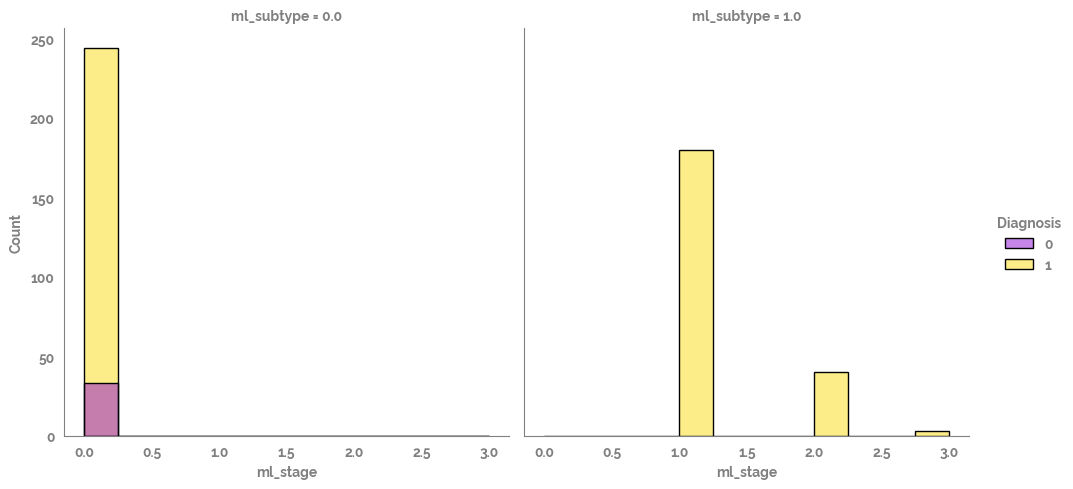

In [125]:
_ = sns.displot(x='ml_stage',hue='Diagnosis', data=zdata,col='ml_subtype')

## Evaluate relationships

One might want to view whether there are relationships between SuStaIn subtype and stage and other variables.

This step should probably be done after you run cross-validation (see below), but we'll do it here first to keep up the momentum

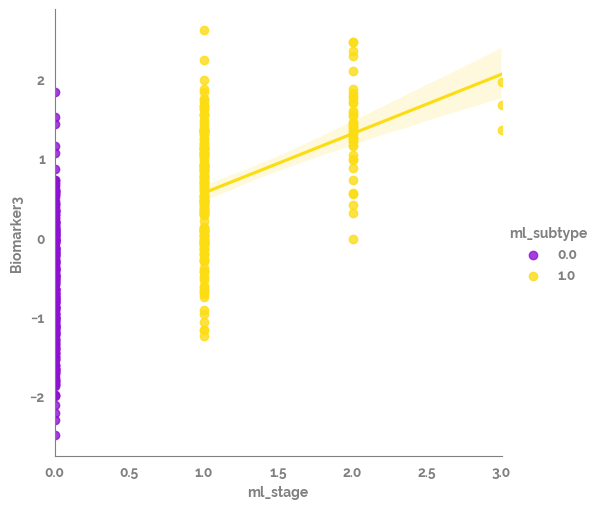

In [132]:
# Plotting relationship between a biomarker and SuStaIn stage across subtypes

var = 'Biomarker3'

# plot relationship
_ = sns.lmplot(x='ml_stage',y=var,hue='ml_subtype',
          data = zdata,
           #lowess=True # uncomment if you would prefer a lowess curve to a linear curve
          )

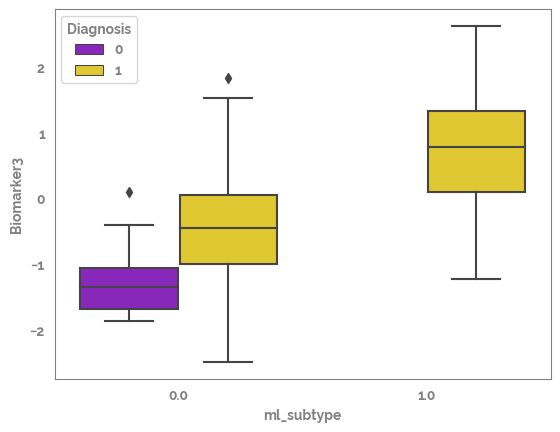

In [134]:
# plot an example variable:

var = 'Biomarker3'
_ = sns.boxplot(x='ml_subtype',y=var,data=zdata, hue="Diagnosis")

## Cross-validation

Finally, it is often difficult to decide how many subtypes best fit your data. This question should ideally be evaluated using cross-validation. This way, the likelihood metrics are generated for data that the model has not yet seen. 

In [136]:
# choose the number of folds - here i've used three for speed but i recommend 10 typically
N_folds = 3

# generate stratified cross-validation training and test set splits
labels = zdata.Diagnosis.values
cv = StratifiedKFold(n_splits=N_folds, shuffle=True)
cv_it = cv.split(zdata, labels)

# SuStaIn currently accepts ragged arrays, which will raise problems in the future.
# We'll have to update this in the future, but this will have to do for now
test_idxs = []
for train, test in cv_it:
    test_idxs.append(test)
test_idxs = np.array(test_idxs,dtype='object')

In [137]:
# perform cross-validation and output the cross-validation information criterion and
# log-likelihood on the test set for each subtypes model and fold combination
CVIC, loglike_matrix     = sustain_input.cross_validate_sustain_model(test_idxs)

Folds:   0%|          | 0/3 [00:00<?, ?it/s]

Finding ML solution to 1 cluster problem


Overall ML likelihood is -2925.8514615643726


MCMC Iteration: 100%|██████████| 10000/10000 [00:06<00:00, 1466.51it/s]


Splitting cluster 1 of 1
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation


- ML likelihood is [-2915.83620169]
Overall ML likelihood is [-2915.83620169]


MCMC Iteration: 100%|██████████| 10000/10000 [00:13<00:00, 744.67it/s]


Splitting cluster 1 of 2
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-2916.87084341]
Splitting cluster 2 of 2
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation


- ML likelihood is [-2915.70811384]
Overall ML likelihood is [-2915.70811384]


Folds:  33%|███▎      | 1/3 [05:54<11:49, 354.95s/it]

Finding ML solution to 1 cluster problem


Overall ML likelihood is -2909.1942345900197


MCMC Iteration: 100%|██████████| 10000/10000 [00:06<00:00, 1459.00it/s]


Splitting cluster 1 of 1
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation


- ML likelihood is [-2897.58739115]
Overall ML likelihood is [-2897.58739115]


MCMC Iteration: 100%|██████████| 10000/10000 [00:13<00:00, 740.12it/s]


Splitting cluster 1 of 2
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-2896.94827952]
Splitting cluster 2 of 2
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation


- ML likelihood is [-2896.98015664]
Overall ML likelihood is [-2896.94827952]


Folds:  67%|██████▋   | 2/3 [10:54<05:38, 338.48s/it]

Finding ML solution to 1 cluster problem


Overall ML likelihood is -2938.565036910918


MCMC Iteration: 100%|██████████| 10000/10000 [00:06<00:00, 1467.66it/s]


Splitting cluster 1 of 1
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation


- ML likelihood is [-2921.99112889]
Overall ML likelihood is [-2921.99112889]


MCMC Iteration: 100%|██████████| 10000/10000 [00:14<00:00, 697.76it/s]


Splitting cluster 1 of 2
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation
- ML likelihood is [-2921.87370898]
Splitting cluster 2 of 2
 + Resolving 2 cluster problem
 + Finding ML solution from hierarchical initialisation


- ML likelihood is [-2921.98932582]
Overall ML likelihood is [-2921.87370898]


Folds: 100%|██████████| 3/3 [16:29<00:00, 329.69s/it]

Average test set log-likelihood for each subtype model: [-1464.8471909  -1463.34146558 -1464.57061661]
CVIC for each subtype model: [8771.76906239 8767.96679457 8776.06721456]


## Choosing the optimal number of subtypes
The optimal number of subtypes is chosen using the CVIC, shown below. The CVIC is an information criterion (like the AIC/BIC/WAIC) that balances model complexity with model accuracy, with a lower CVIC indicating a better balance between the two. Generally speaking, the model with the lowest CVIC is the best. However, you do sometimes get a very small improvement (less than ~6) in the CVIC with a more complex model, in which case I would tend to favour the less complex (i.e. fewer subtypes) model.

Another useful metric to look at is the log-likelihood of each subtypes model on the test set, also shown below. A better model should show a consistent improvement in the test set log-likelihood across folds.

CVIC for each subtype model: [8771.76906239 8767.96679457 8776.06721456]
Average test set log-likelihood for each subtype model: [-1464.8471909  -1463.34146558 -1464.57061661]


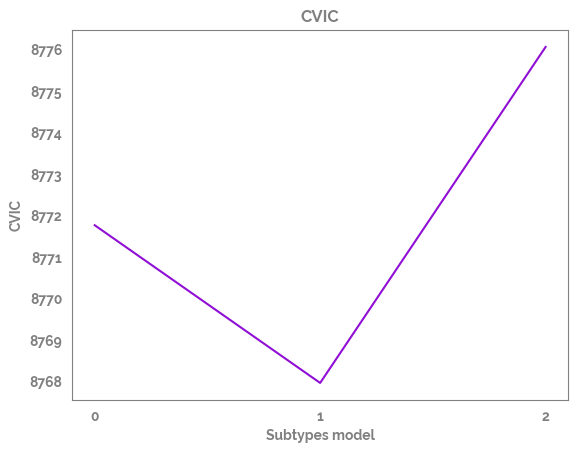

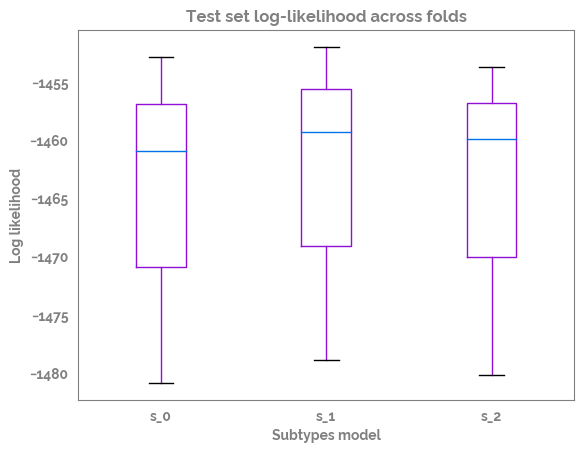

In [138]:
# go through each subtypes model and plot the log-likelihood on the test set and the CVIC
print("CVIC for each subtype model: " + str(CVIC))
print("Average test set log-likelihood for each subtype model: " + str(np.mean(loglike_matrix, 0)))

plt.figure(0)    
plt.plot(np.arange(N_S_max,dtype=int),CVIC)
plt.xticks(np.arange(N_S_max,dtype=int))
plt.ylabel('CVIC')  
plt.xlabel('Subtypes model') 
plt.title('CVIC')

plt.figure(1)
df_loglike = pd.DataFrame(data = loglike_matrix, columns = ["s_" + str(i) for i in range(sustain_input.N_S_max)])
df_loglike.boxplot(grid=False)
plt.ylabel('Log likelihood')  
plt.xlabel('Subtypes model') 
_ = plt.title('Test set log-likelihood across folds')

Another useful output of the cross-validation that you can look at are positional variance diagrams averaged across cross-validation folds. These give you an idea of the variability in the progression patterns across different training datasets.

/opt/miniconda3/envs/ds_env/lib/python3.8/site-packages/pySuStaIn/ZscoreSustain.py:505: UserWarning: Both labels and an order have been given. The labels will be reordered according to the given order!
  warnings.warn(
/opt/miniconda3/envs/ds_env/lib/python3.8/site-packages/pySuStaIn/AbstractSustain.py:522: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


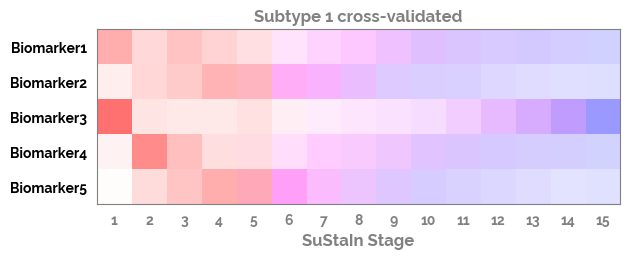

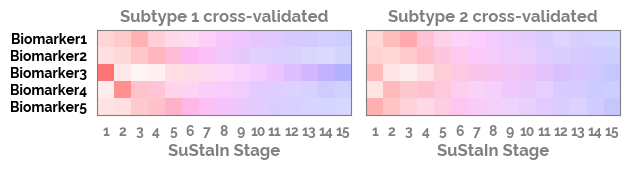

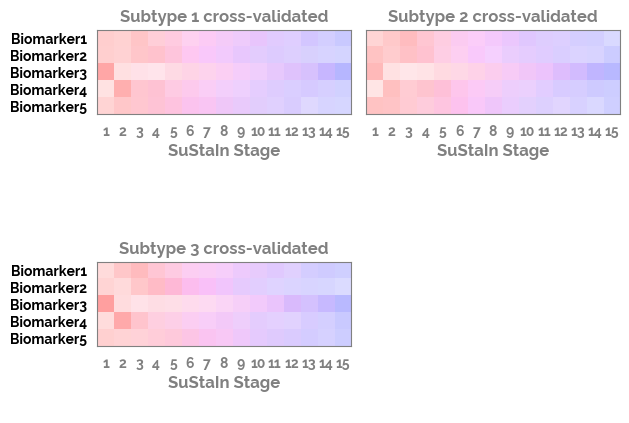

In [139]:
#this part estimates cross-validated positional variance diagrams
for i in range(N_S_max):
    sustain_input.combine_cross_validated_sequences(i+1, N_folds)

/opt/miniconda3/envs/ds_env/lib/python3.8/site-packages/pySuStaIn/ZscoreSustain.py:505: UserWarning: Both labels and an order have been given. The labels will be reordered according to the given order!
  warnings.warn(
/opt/miniconda3/envs/ds_env/lib/python3.8/site-packages/pySuStaIn/AbstractSustain.py:522: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


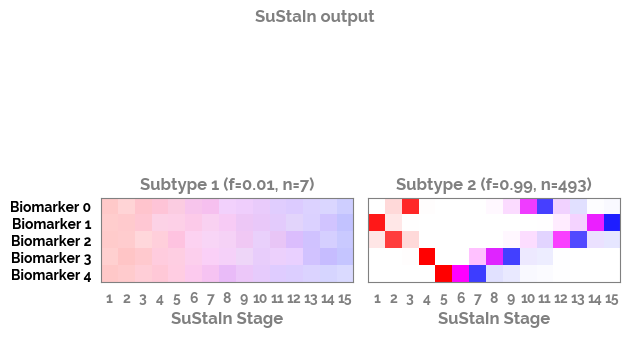

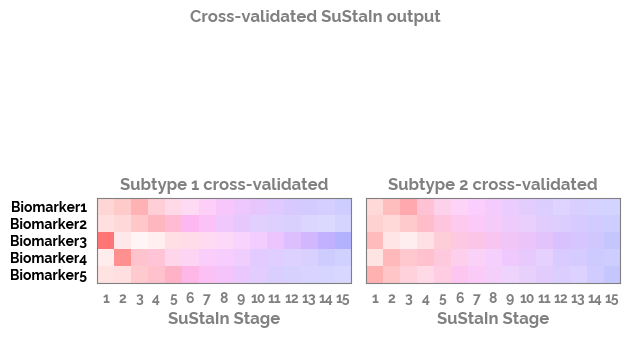

In [141]:
N_S_selected = 2

ps.ZscoreSustain._plot_sustain_model(sustain_input,samples_sequence,samples_f,M,subtype_order=(0,1))
_ = plt.suptitle('SuStaIn output')

sustain_input.combine_cross_validated_sequences(N_S_selected, N_folds)
_ = plt.suptitle('Cross-validated SuStaIn output')